<a href="https://colab.research.google.com/github/williamedwardhahn/OISC/blob/main/Hahn_MPCR_OISC_Logo_October_3rd_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MPCR OISC

In [1]:
# Thing <- Name of the thing <- Name of the Name of the thing

In [71]:
import numpy as np
import matplotlib.pyplot as plt

N = 4096

def load_from_string(content):

    content += '''PS'''

    lines = [line.split('#')[0].strip() for line in content.split("\n") if line.split('#')[0]]

    C = np.zeros(N, dtype='object')
    D = {}
    i = 0
    for line in lines:

        tokens = line.strip().replace(',', ' ').split()
        D[tokens[0]] = i
        code = [D[token] if token in D else int(token) for token in tokens[1:]]

        if code:
            C[i] = i + 1
            C[i+1:i+1+len(code)] = code
            i += len(code) + 1
        else:
            i += 1

    return C, D


In [80]:
code_ai = """
IP    # Instruction Pointer
A     # ALU Operand Register
B     # ALU Operand Register
C     # AUX Register
X     # AUX Register
Y     # AUX Register
Z     # AUX Register
I     # Loop Index
J     # Loop Index
K     # Loop Index
Add
Sub
Mult
Div
Equal
Greater
Lesser
L
S
W
P
Halt 0,L L,0
Push A,S W,0
Peek S,A A,S W,0
Pop S,A W,0
Drop S,C W,0
Dup S,A A,S A,S W,0
Swap S,B S,A B,S A,S W,0
Zero 0,L L,S W,0
One 1,L L,S W,0
+ S,B S,A Add,S W,0
- S,B S,A Sub,S W,0
* S,B S,A Mult,S W,0
/ S,B S,A Div,S W,0
Not S,A -1,L L,B Mult,A 1,L L,B Add,S W,0
Negate S,A -1,L L,B Mult,S W,0
Rot S,C S,B S,A C,S A,S B,S W,0
Continue A,A W,0
Branch Dup,W Not,W Rot,W *,W Rot,W *,W +,W S,A A,W W,0
If Continue,S Rot,W Branch,W W,0
Square Dup,W *,W W,0
Cube Dup,W Square,W *,W W,0
Fourth Square,W Square,W A,A W,0
Double Dup,W +,W W,0
-- S,A 1,L L,B Sub,S W,0
++ S,A 1,L L,B Add,S W,0
== S,B S,A Equal,S W,0
> S,B S,A Greater,S W,0
< S,B S,A Lesser,S W,0
Word1 Double,W W,0
Apple 0
Orange 0
! S,A S,P W,0
@ S,A P,S W,0
Halve S,A 2,L L,B Div,S W,0
Over S,B S,A A,S B,S A,S W,0
Mod S,Y S,X X,A Y,B Div,A Mult,B X,A Sub,S W,0
I-- I,S --,W S,I W,0
I++ I,S ++,W S,I W,0
I--Y0 I,S --,W S,I Y,0 W,0
Loop S,I I--,W S,X IP,Y X,W Continue,S I--Y0,S I,S One,W >,W Branch,W W,0
SL 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
WL 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
Text 3 97 98 99 0  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
"""

C, D = load_from_string(code_ai) # Codes, Dictionary

In [81]:
#Decompiler
D2 = {v: k for k, v in D.items()}  # invert D
print(f"{'Index':<8}{'Name':<16}{'Code':<16}{'Decode':<16}")
for i in range(len(C) - 3500):  # Just showing the first 3 rows as an example
    value_name = D2.get(C[i], '')  # Check if the value has a corresponding name in D2
    if i in D2:
        print(f"{i:<8}{D2[i]:<16}{C[i]:<16}{value_name:<16}")
    else:
        print(f"{i:<8}{'':<16}{C[i]:<16}{value_name:<16}")


Index   Name            Code            Decode          
0       IP              0               IP              
1       A               0               IP              
2       B               0               IP              
3       C               0               IP              
4       X               0               IP              
5       Y               0               IP              
6       Z               0               IP              
7       I               0               IP              
8       J               0               IP              
9       K               0               IP              
10      Add             0               IP              
11      Sub             0               IP              
12      Mult            0               IP              
13      Div             0               IP              
14      Equal           0               IP              
15      Greater         0               IP              
16      Lesser          0      

In [82]:
def compile_program(X):
    program = []
    for x in X.split(' '):
        if x.lstrip("-").isdigit():
            program += [int(x), D['L'], D['L'], D['S']]
        elif "," in x:
            a, b = map(lambda y: int(y) if y.lstrip("-").isdigit() else D[y], x.split(','))
            program += [a, b]
        else:
            program += [D[x], D['W']]
    program += [0, D['L'], D['L'], D['IP']]
    return program



def setup(program):
    program = compile_program(program)
    M = np.zeros(N, dtype=int)
    M[:len(C)] = C
    M[D["PS"]:D["PS"] + len(program)] = program
    M[D["IP"]] = D["PS"]
    M[D["SL"]] = 0
    M[D["WL"]] = 0
    return M




def run(M):

    IP, A, B, C, Add, Sub, Mult, Div, L, P, S, SL, W, WL, Equal, Greater, Lesser = (D[x] for x in ["IP", "A", "B", "C", "Add", "Sub", "Mult", "Div", "L", "P", "S", "SL", "W", "WL", "Equal", "Greater", "Lesser"])


    while M[IP] > 0:

        M[IP] += 2

        a,b = M[IP]-2 , M[IP]-1  # a is pointer to address i, b is pointer to address j
        i,j = M[a]    , M[b]     # copy from address i paste in address j


        if i == S and j == L:
            M[L] = i
        elif i == W and j == L:
            M[L] = i

        elif j == L:
            M[L] = i

        elif i == S:
            M[j] = M[SL + M[SL]]
            M[SL] -= 1
        elif j == S:
            M[SL] += 1
            M[SL + M[SL]] = M[i]

        elif i == W:
            M[j] = M[WL + M[WL]]
            M[WL] -= 1
        elif j == W:
            M[WL] += 1
            M[WL + M[WL]] = M[0]
            M[0] = M[i]

        elif i == P:
            M[j] = M[M[A]]
        elif j == P:
            M[M[A]] = M[i]

        else:
            M[j] = M[i]


        #Memory Mapped ALU
        M[Add]  = M[A] + M[B]
        M[Sub]  = M[A] - M[B]
        M[Mult] = M[A] * M[B]
        M[Div]  = 0 if M[B] == 0 else M[A] // M[B]

        M[Equal]   = M[A] == M[B]
        M[Greater] = M[A] > M[B]
        M[Lesser]  = M[A] < M[B]


    return M



In [83]:
# Test data
number_test_programs = [(f"{i}", [i]) for i in range(100)]

test_programs = [
    ("10 11 +", [21]),                                     # Add 10 and 11
    ("10 3 -", [7]),                                       # Subtract 3 from 10
    ("8 9 *", [72]),                                       # Multiply 8 by 9
    ("10 2 /", [5]),                                       # Divide 10 by 2
    ("10 3 >", [1]),                                       # Check if 10 is greater than 3
    ("3 5 >", [0]),                                        # Check if 3 is greater than 5
    ("1 Not", [0]),                                        # Logical NOT of 1
    ("5 Fourth", [625]),                                   # Raise 5 to the power of 4
    ("8 9 * 7 + Fourth", [38950081]),                      # Multiply 8 and 9, add 7, and raise the result to the power of 4
    ("0 Not", [1]),                                        # Logical NOT of 0
    ("-5 Negate", [5]),                                    # Negate -5
    ("6 --", [5]),                                         # Decrement 6 by 1
    ("3 Double", [6]),                                     # Double the value 3
    ("3 5 -", [-2]),                                       # Subtract 5 from 3
    ("3 5 >", [0]),                                        # Check if 3 is greater than 5
    ("0 5 >", [0]),                                        # Check if 0 is greater than 5
    ("6 5 >", [1]),                                        # Check if 6 is greater than 5
    ("5 Double,S Fourth,S One Branch", [625]),             # Double 5, raise it to the power of 4, and branch based on 1 (true)
    ("5 Double,S Fourth,S Zero Branch", [10]),             # Double 5, raise it to the power of 4, and branch based on 0 (false)
    ("5 Continue,S Fourth,S One Branch 22 1 +", [625,23]), # Continue with operations, raise 5 to the power of 4, branch based on 1, add 22 and 1
    ("4 Halve", [2]),                                      # Divide 4 by 2
    ('2 4 + 3 -', [3]),                                    # Simple arithmetic
    ('2 2 2 2 2 + + + +', [10]),                           # Stacking operations
    ('5 2 * 10 /', [1]),                                   # Multiplication followed by division
    ('5 2 <', [0]),                                        # Lesser than check
    ('2 5 <', [1]),                                        # Lesser than check
    ('5 5 ==', [1]),                                       # Equality check
    ('5 3 ==', [0]),                                       # Non-equality check
    ('5 3 > 4 +', [5]),                                    # Greater than check with subsequent addition
    ('6 3 / 2 *', [4]),                                    # Division followed by multiplication
    ('2 5 > 3 4 + +', [7]),                                # Greater than check with subsequent operations
    ("10 3 Over", [10, 3, 10]),
    ("3 Cube", [27]),
    ("10 3 6 Rot", [6, 10, 3]),
    ("7 4 Mod", [3]),
    ("10 3 Mod", [1]),
    ("5 Continue,S Double,S One Branch", [10]),
    ("5 Double,S One If", [10]),
    ("5 Double,S Zero If", [5]),
    ("2 Word1,S 10 Loop", [1024]),
    ("2 Word1,S 8 Loop", [256]),
    ("5 S,Apple 10 Drop,W Apple,S", [5]),
    ]

for i, (program, expected_answer) in enumerate(number_test_programs):
    M = setup(program)
    M = run(M)
    answer = M[D['SL']+1:D['SL']+1+M[D['SL']]]
    assert np.array_equal(answer, np.array(expected_answer)), f'Test {program} failed. Expected {expected_answer}, but got {answer.tolist()}.'

for i, (program, expected_answer) in enumerate(test_programs):
    M = setup(program)
    M = run(M)
    answer = M[D['SL']+1:D['SL']+1+M[D['SL']]]
    assert np.array_equal(answer, np.array(expected_answer)), f'Test {program} failed. Expected {expected_answer}, but got {answer.tolist()}.'

print('All tests passed.')

All tests passed.


#Display

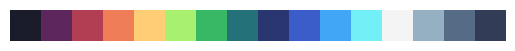

In [91]:
import matplotlib.colors as mcolors
import imageio.v2 as imageio

def get_colors_lospec(im_array, N):
    rgb_list = im_array[0, :, :3] / 255
    float_list = np.linspace(0, 1, len(rgb_list))
    cdict = {}
    for num, col in enumerate(['red', 'green', 'blue']):
        cdict[col] = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
    return mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=N)
im = imageio.imread('https://lospec.com/palette-list/sweetie-16-1x.png')
color_map = get_colors_lospec(im, im.shape[1])
plt.imshow(im, cmap=color_map),plt.axis('off');

n = 50
display = "DL" + n*n*" 0" + "\n"

def monitor():
    plt.imshow(M[D['DL']+1:D['DL']+n*n+1].reshape(n,n), cmap=color_map, vmin=0, vmax=colors)
    plt.colorbar()
    plt.show()
    plt.pause(0.1)

In [100]:
new_code = '''
TurtleX
TurtleY
TurtleI
TurtleC
TurtleN
TurtleX-- TurtleX,S --,W S,TurtleX W,0
TurtleX++ TurtleX,S ++,W S,TurtleX W,0
TurtleY-- TurtleY,S --,W S,TurtleY W,0
TurtleY++ TurtleY,S ++,W S,TurtleY W,0
TurtleI++ TurtleI,S ++,W S,TurtleI W,0
Paint S,A TurtleC,P Drop,W W,0
UpdateTurtleI TurtleY,S TurtleN,S *,W TurtleX,S +,W DL,S +,W S,TurtleI W,0
Draw TurtleC,S UpdateTurtleI,W TurtleI,S Paint,W W,0
Start 50,L L,TurtleN 5,L L,TurtleX 5,L L,TurtleY 700,L L,TurtleI 1,L L,TurtleC Draw,W W,0
Up TurtleY--,W Draw,W W,0
Down TurtleY++,W Draw,W W,0
Left TurtleX--,W Draw,W W,0
Right TurtleX++,W Draw,W W,0
PenUp 0,L L,TurtleC W,0
PenDown 1,L L,TurtleC W,0
DrawSquare Right,S 10,L L,S Loop,W Down,S 10,L L,S Loop,W Left,S 10,L L,S Loop,W Up,S 10,L L,S Loop,W W,0
# Notes Go Here
DrawA PenUp,W Right,W PenDown,W Right,S 3,L L,S Loop,W PenUp,W Right,W Down,W PenDown,W Down,S 4,L L,S Loop,W W,0

DrawSquares DrawSquare,W Right,S 9,L L,S Loop,W 5,L L,S S,TurtleC DrawSquare,W Right,S 9,L L,S Loop,W 11,L L,S S,TurtleC DrawSquare,W Right,S 9,L L,S Loop,W 3,L L,S S,TurtleC DrawSquare,W W,0
'''

In [101]:
code0 = code_ai + display + new_code

In [102]:
C, D = load_from_string(code0) # Codes, Dictionary

In [103]:
program = "Start DrawSquares"
M = setup(program)

In [104]:
%%timeit
run(M)

1.93 µs ± 78.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [105]:
M = run(M)

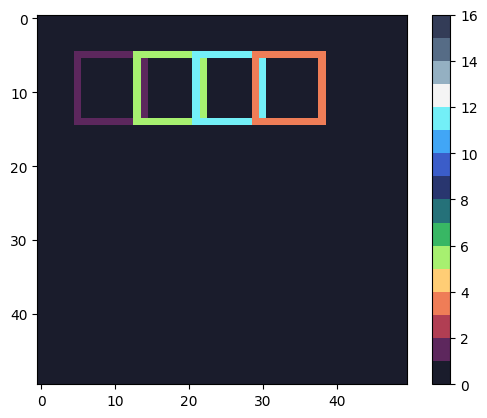

In [106]:
monitor()

In [61]:
def REPL(M):

    while True:

        print(M[D['SL']+1:D['SL']+1+M[D['SL']]])
        monitor()

        program = input()

        if program == "Exit": break

        program = compile_program(program)

        M[D["PS"]:D["PS"] + len(program)] = program
        M[0] = D["PS"]

        M = run(M)

In [ ]:
program = "0"
M = setup(program)
REPL(M)

#Notes

In [ ]:
D['Text']
M[D['Text']]
M[M[D['Text']]]
chr(97)
output = ''.join([chr(i) for i in M[M[D['Text']]+1:M[D['Text']]+1+M[M[D['Text']]]]])
print(output)

In [ ]:
# if program == "Exit": break

In [ ]:
# https://www.dafont.com/img/charmap/r/e/retro_computer0.png